# Group Meeting 2

Conditional probability, Bayes' rule, entropy (classical, joint, conditional, residual, relative)

### Readings 

Chapter 3, up through 3.2.1 of Bossomaier et al. (stop when you get to Mutual Information), https://link.springer.com/book/10.1007/978-3-319-43222-9


Sections 1.1, 1.2, 1.3 of Feldman's tutorial notes.
http://hornacek.coa.edu/dave/Tutorial/notes.pdf

**"Extra Credit" Reading**: Simon DeDeo's *"Information Theory for Intelligent People"* 
http://tuvalu.santafe.edu/~simon/it.pdf

### Data
We'll be working with the same, binarized, HCP data as last time. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns #Seaborn is a wrapper for matplotlib - it makes everything prettier.
sns.set(style="white")
from copy import deepcopy
from collections import Counter
from scipy.stats import zscore

#To save disk space, I've saved the HCP data as a compressed .npz array.
#You can load it into the workspace with np.load(), although it cannot be directly accessed. 
data = np.load("data/HCP_BOLD.npz")
bold = zscore(data["signal"], axis=1) #Z-scored for data-hygiene reasons.
#For those that don't know: to z-score data is to subtract the mean, and divide by the standard deviation. 
#This results in data distributed around 0 w/ unit deviation. It does not make things Gaussian, but makes 
#things generally nicer.

discrete = deepcopy(bold) #This is a handy utility function, for Python-people whow haven't seen it before. 
discrete[discrete > 0] = 1 #Numpy indexing at work.
discrete[discrete < 0] = 0
discrete = discrete.astype("int16") #Use small integers if you can get away with it. Easier on RAM. 

### Conditional Probability

Along with individual and joint probabilities, condition probability is one of the basic building-blocks of probability theory. For two variables $X$ and $Y$, with support sets $\mathcal{X},\mathcal{Y}$, the condition probability $P(X = x | Y = y)$ is read as "the probability that variable $X$ is in some state $x$, given that you know that varaible $Y$ is simultaniously in state $y$." Conditional probability can be related to the joint probability by:

$\begin{equation}
P(X,Y) = P(X | Y)P(Y) = P(Y | X)P(X)
\end{equation}$ 

This allows a handy derivation that:

$\begin{equation}
P(X | Y) = \frac{P(X,Y)}{P(Y)}
\end{equation}$

If and only if $X$ and $Y$ are independent can we say that:

$\begin{equation}
P(X|Y) = P(X)
\end{equation}$

As with the case that, for independent variables, the join probability is equal to the product of the marginals, *you should not always assume that this relationship holds. In fact, in complex systems of multiple interacting variables, it almost never does!*

Conditional probability is one of the places whe the philosophy of probability gets interesting. A frequentist would argue that conditional probability is just about the number of times different combinations of $X$ and $Y$ occur together, over infinite time. When we actually want to estimate conditional probabilities from data, this is often the logic we feed the computer. However, a more philosphical/cognitive (and quasi-Bayesian) perspective is that the conditional probability hinges, not on anything intrinsic to $X$ or $Y$, but rather your *knowledge* about the state of $Y$. Intuitively, we tend to feel that the *actual* probability of $X=x$ should independent of the state of our knowledge or beliefs (what Bayesians call *priors*), however, depending on how you fall on the frequentist/Bayesian divide, you may be tempted to believe that the value $P(X=x)$ does not exist in any ontological sense, and instead is only ever a function of the state we believe the rest of the world to be in.

#### Bayes' Theorem

The relationship between the joint, marginal and independent probabilites allows us to derive Bayes Theorem - something every aspiring complex systems scientist should be deeply familiar with. The derivaiton is simple and hinges on the symmetrical nature of the joint probability:

\begin{eqnarray}
P(X,Y) = P(X|Y)P(Y) \\
P(X|Y)P(Y) = P(Y|X)P(X) \\
P(X|Y) = \frac{P(Y|X)P(X)}{P(Y)}
\end{eqnarray}

This can lead to some non-intuitive (but profoundly important results). I won't go through an entire derivation, but one example is medical testing. Medical tests are often advertised as being "95% accurate!" which many interpret to mean: "if this test comes back positive, then there's a 95% chance I have the disease." Formally, what they think they're getting is:

$P(Disease = True | Test = +)$

What the advertisement really means, however is that the test has a low false-negative rate, i.e.:

$P(Test = + | Disease = True)$ 

These are obviously *not* identical, but Bayes rule gives us a way to calculate the information you really want, provided you can figure out what the probability of having the disease in the first place is (i.e. $P(Disease = True)$), and the probability of ever seeing a positive test results (i.e. $P(Test = +)$).

#### Conditional probability demo

We'll take two timeseries from our discrete dataset and calculate:

$P(X_0 = 0)$, $P(X_0 = 1)$, as well as $P(X_0 = 0 | X_1 = 0)$ and $P(X_0 = 1 | X_1 = 0)$

In [15]:
ch0 = discrete[0]
ch1 = discrete[1]

#Calculating the individual probabilities is easy. Just count how many times each state appears
#and divide by the number of observations (in this case, the total number of frames).
C0 = Counter(ch0)
C1 = Counter(ch1)
print("P(Ch_0 = 0)", round(C0[0] / ch0.shape[0], 3)) #round() is a handy Python function.
print("P(Ch_0 = 1)", round(C0[1] / ch0.shape[0], 3))

P(Ch_0 = 0) 0.469
P(Ch_0 = 1) 0.531


In [30]:
#Recall from above that P(X|Y) = P(X,Y)/P(Y):
#This requires constructing the joint probability distribution for Ch0 and Ch1
joint = list(zip(ch0, ch1))
C_joint = Counter(joint)
probs_joint = {key : C_joint[key] / sum(C_joint.values()) for key in C_joint.keys()}

#For readability, we will also turn the counts in C0 and C1 into probabilities. 
probs_0 = {key : C0[key] / sum(C0.values()) for key in C0.keys()}
probs_1 = {key : C1[key] / sum(C1.values()) for key in C1.keys()}

print("P(Ch_0 = 0 | Ch_1 = 0):", round(probs_joint[(0,0)] / probs_1[0], 10))
print("P(Ch_0 = 0 | Ch_1 = 1):", round(probs_joint[(0,1)] / probs_1[1], 10))

P(Ch_0 = 0 | Ch_1 = 0): 0.5566666667
P(Ch_0 = 0 | Ch_1 = 1): 0.3816666667


Note that these don't necessarilly have to sum to 1 (look up the Law of Total Probability for more on this).

### Shannon Entropy

Moving on from conditional probability (which was the final "atom" of probability theory we needed), now we have all tools required to really dig into entropy. There are three ways that entropy of a single variable (the Shannon entropy) is commonly intuitively understood, all are equivalent, mathematically, and it is worth considering how these three definitions relate to each-other. 

1) **Entropy as the expected surprise.** Recall that the expected value of a distribution $P(X)$ under some value function $f(x)$ is given by:

\begin{equation}
E[P(X)] = \sum_{x\in\mathcal{X}} P(X=x)f(X=x)
\end{equation}

When our value function is the "surprisal" (also called the Shannon information content) given by $\log\big(\frac{1}{P(X)}\big)$, then we define the entropy of a distribution $H(X)$ as:

\begin{eqnarray}
H(X) &=& \sum_{x\in\mathcal{X}}P(X=x)\log\big(\frac{1}{P(X=x)}\big) \\
&=& -\sum_{x\in\mathcal{X}}P(X=x)\log\big(P(X=x)\big)
\end{eqnarray}

Note that, while $\log(0)$ and $0\times\log(0)$ are technically undefined, by convention, $0\times\log(0)=0$ in information theory. Plot the fuction $f(x)=x\log(x)$ to see why that is not totally innapropriate. The intuition is that this ensures that elements outside of $\mathcal{X}$ have no effect on the information-structure of the variable.

Typically the lower form is what is seen most commonly, although they are identical. This perspective defines entropy as a measure of, on average, how surprising is every individual possible outcome of $X$. Conviently, entropy is *always positive.* In general, if you have gotten a negative value of $H(X)$, you have done something terribly wrong. Negative information values (almost) never make sense.

2) **Entropy as the average number of yes/no quesitons needed to determine the value of a variable.** The intuition for this is reasonably clear. Imagine some variable $X$ with the following probability distribution: $P(X) := \{P(X=x_1)=1/2, P(X=x_2)=1/4, P(X=x_3)=1/4\}$. If you were playing a game where you knew that distribution, but not the actual value of $X$ and wanted to guess the state of $X$ using the fewest number of yes/no quesitons, how would you play? 

You'd start by asking "is $X=x_1$?" Half the time, you'd be right, and the game would be over. 

If it's not $x_1$, then the obvious next question to ask is "is $X=x_2$?" After all, if it's not $x_1$, then it's just as likely to be $x_2$ as it is to be $x_3$. 

If it turns out you're wrong about it being $x_2$, you automatically know it's $x_3$ and the game is over. If we calculate the average number of questions asked, it works out to be:

\begin{equation}
H(X) = \frac{1}{2}(1) + \frac{1}{2}(2) = 1.5\text{ bit}
\end{equation}

If we plug the distribution above into $-\sum (P(X)\log(P(X))$ above, we get the same number out.

3) **Entropy as uncertainty about the state of a variable.** Finally, the intuition most commonly used in Complex Systems is that entropy quantifies how uncertain we about the state of the variable (or system) under study. As Feldman notes, Shannon's entropy function satisfies a number of intuitions. Namely that: when the state of the system is known with certainty, the entropy should be $0$ (i.e. there is no uncertainty) and when the probability distribution of states is flat, entropy is maximal (i.e. we have no reason to expect any state over any other). Furthermore, we would like the entropy is invariant under different groupings of states (again, see Feldman 1.2.1 for an example), and that the function itself is continous (no weird asymptotes, small changes in $P(X)$ lead onlly to small changes in $H(X)$).

You can prove (although we won't here) that the *only* function that satisfies those four criteria is $H(X) = -\sum P(X)\log(P(X))$.

### Joint Entropy 

As with probabilities, we can quantify how much uncertainty is contained within two variables, and like the other information theory measures, it is typically given as the expectation over a distribution of (joint) states (although the other two interpretations are also equally valid).

\begin{equation}
H(X,Y) = \sum_{x\in\mathcal{X}}\sum_{y\in\mathcal{Y}}P(X=x, Y=y)\log(P(X=x,Y=y))
\end{equation}

The joint entropy generalizes to multivariate systems quite nicely:

\begin{equation}
H(X_1,...X_n) = -\sum_{x_1\in\mathcal{X_1}}...\sum_{x_n\in\mathcal{X_n}}P(x_1...x_n)\log(P(x_1...x_n))
\end{equation}

(Note we have compactified the notation here, which we will do from here on out). 
You can also look at the joint states of groups of variables, in which case we often concatenate them without commas. For example, for four variables, we might be interested in the joint states of {X,Y} and {A,B}, which we would write $H(XY,AB)$.

We have already briefly explored constructing joint probability spaces in the last Notebook, but will revisit the essential logic here, again. 

In [74]:
#These have already been defined above - showing it again just for completeness sake. 
C_joint = Counter(list(zip(ch0, ch1)))
probs_joint = {key : C_joint[key] / sum(C_joint.values()) for key in C_joint.keys()}

H_joint = -1*sum((probs_joint[key]*np.log2(probs_joint[key]) for key in probs_joint.keys()))
print("H(Ch0,Ch1) =", round(H_joint, 3))

H(Ch0,Ch1) = 1.975


From this we can see that the joint entropy is slightly lower than what we would expect if both channels were totally random (i.e. $P(Ch 0 = 0) = P(Ch 0 = 1) = 1/2$) and both were independent. This highlights a nice property of joint entropy: the joint entropy will always be *less* that the sum of the individual entropies togther, but greater than any single consituent entropy considered alone. 

The logic is the same if we include more channels. 

In [43]:
ch2, ch3 = discrete[2], discrete[3]
C_joint = Counter(list(zip(ch0, ch1, ch2, ch3)))
C_joint

Counter({(0, 0, 0, 0): 180,
         (0, 0, 0, 1): 48,
         (0, 0, 1, 0): 76,
         (0, 0, 1, 1): 30,
         (0, 1, 0, 0): 105,
         (0, 1, 0, 1): 76,
         (0, 1, 1, 0): 18,
         (0, 1, 1, 1): 30,
         (1, 0, 0, 0): 47,
         (1, 0, 0, 1): 23,
         (1, 0, 1, 0): 100,
         (1, 0, 1, 1): 96,
         (1, 1, 0, 0): 32,
         (1, 1, 0, 1): 90,
         (1, 1, 1, 0): 38,
         (1, 1, 1, 1): 211})

In [44]:
probs_joint = {key : C_joint[key] / sum(C_joint.values()) for key in C_joint.keys()}

H_joint = -1*sum({probs_joint[key]*np.log2(probs_joint[key]) for key in probs_joint.keys()})
print("H(Ch0,Ch1,Ch2,Ch3) =", round(H_joint, 3))

H(Ch0,Ch1,Ch2,Ch3) = 3.281


### Conditional Entropy

Conditional entropy is the uncertainty you have about a variable $X$, after accounting for the states of variable $Y$. It is very important that you remember that entropy is *uncertainty* - you can think of the conditional entropy as the uncertainty in $X$ that is intrinsic to it, or not explicable using information about the state of $Y$.

Typically denoted as:

\begin{equation}
H(X | Y) = -\sum_{x\in\mathcal{X}}\sum_{y\in\mathcal{Y}}P(X,Y)\log(P(X|Y))
\end{equation}

This formula may look a little surprising (we are used to things for the form $P(X)f(P(X))$, but here we have a conditional probability on the inside of the log and and joint probability outside of it). This has to do with needing to condition all possible states of $X$ on all possible states of $Y$. If we are only interested in one possible state of $Y$, then the restricted conditional entropy is

\begin{equation}
H(X | Y=y) = -\sum_{x\in\mathcal{X}}P(X|Y=y)\log(X|Y=y)
\end{equation}

Which is in the more familiar shape of an entropy measure. Unfortunately, this only accounts for the effect of a specific state $y$. If we want information from all possible states of $Y$, we need to average over the distribution of $Y$'s states, which becomes:

\begin{equation}
H(X | Y) = \sum_{y\in\mathcal{Y}}P(Y=y)H(X|Y=y)
\end{equation}

What we have here, then is nested expectations: the expected entropy of $X$ given some static $Y=y$, and then the expected value of *that* over all possible static $Y=y$ states. This also explains why the equation immediatley above doesn't have the negative sign in front of it: that negative is "hidden" in $H(X|Y=y)$.

When you work out the math, you get the original formulation given above. 

Conditional entropy can also be written in terms of joint and individual entropies:

\begin{equation}
H(X|Y) = H(X,Y) - H(Y)
\end{equation}

Intuitively, this makes sense: the uncertainty about $X$ conditioned on $Y$ is the amount of uncertainty *left over* when you remove the uncertainty from $Y$ from the joint states of both. Again, it is important to remember that entropy is a measure of *uncertainty* NOT *information.* There is a tendency for students to read $H(X|Y)$ as "the information that $Y$ gives me about $X$. This is NOT the case. It is the uncertainty about $X$ left over when information about the state $Y$ is accounted for. 

In [75]:
#We can easily calculate the entropy of Ch. 0 given Ch. 1 and vice versa:
C0 = Counter(ch0)
C1 = Counter(ch1)

probs_0 = {key : C0[key] / sum(C0.values()) for key in C0.keys()}
probs_1 = {key : C1[key] / sum(C1.values()) for key in C1.keys()}

C_joint = C_joint = Counter(list(zip(ch0, ch1))) #Again, this is already definiedm re-doing for completeness. 
probs_joint = {key : C_joint[key] / sum(C_joint.values()) for key in C_joint.keys()}

H_0 = -1*sum((probs_0[key]*np.log2(probs_0[key]) for key in probs_0.keys()))
H_1 = -1*sum((probs_1[key]*np.log2(probs_1[key]) for key in probs_1.keys()))

print(H_0)
print(H_1)

H_joint = -sum((probs_joint[key]*np.log2(probs_joint[key]) for key in probs_joint.keys()))

print("H(Ch0 | Ch1) = ", H_joint - H_1)
print("H(Ch1 | Ch0) = ", H_joint - H_0)

0.9972551344471869
1.0
H(Ch0 | Ch1) =  0.9749626957207407
H(Ch1 | Ch0) =  0.9777075612735537


Note that these are *not* the same. The conditional entropy function is not symmetrical. Also the condtional probability $H(X|Y)$ will always be smaller than, or equal to $H(X)$, with equality if and only if $X$ and $Y$ are independenet. There is no circumstance in which knowing more about one variable decreases you ability to make predictions about the other.

### Relative Entropy (Kullback-Leibler Divergence)

The relative entropy (or KLD) is a measure of how different two probability distributions (typically noted $P(X)$ and $Q(X)$).

\begin{equation}
D_{KL}(P || Q) = P(X)\log\big(\frac{P(X)}{Q(X)}\big)
\end{equation}

In the context of Bayesian inference, $D_{KL}(P||Q)$ gives the amount of information (or predictive power) gained when one updates one's prior beliefs ($Q(X)$) to the posterior distribution ($P(X)$). Alternately, it can be thought of as the amount of information lost when $Q(X)$ is used to approximate $P(X)$. 

Consider two distributions:

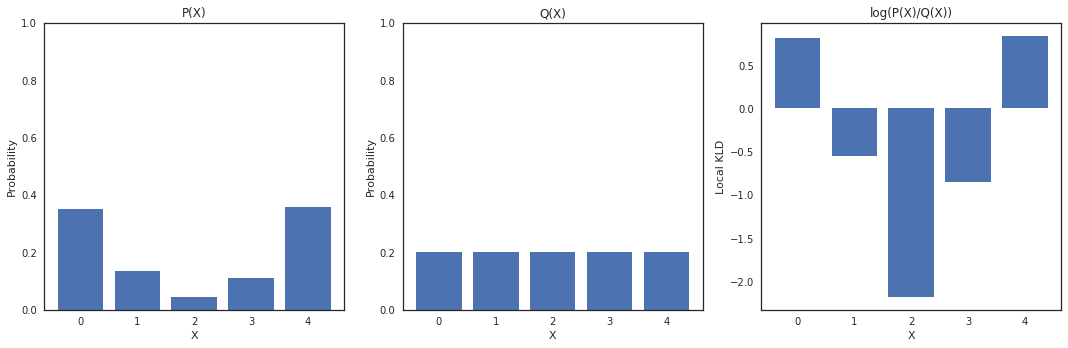

In [113]:
px = np.random.randint(1,101,5)
px = px / np.sum(px)
qx = np.repeat(1/5, 5)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.bar(np.arange(5), px)
plt.ylim([0,1])
plt.title("P(X)")
plt.xlabel("X")
plt.ylabel("Probability")

plt.subplot(1,3,2)
plt.bar(np.arange(5), qx)
plt.ylim([0,1])
plt.title("Q(X)")
plt.xlabel("X")
plt.ylabel("Probability")

plt.subplot(1,3,3)
plt.bar(np.arange(5), np.log2(px/qx))
plt.title("log(P(X)/Q(X))")
plt.xlabel("X")
plt.ylabel("Local KLD")

plt.tight_layout()

We are interested in the element-wise differences between $Q(X=x)$ and $P(X=x)$.

Working with the Shannon information content, we get $[-\log(Q(X=x))] - [-\log(P(X=x))]$. We subtract P(X) from Q(X) to get the "error" between the two distributions: how far is distribution $Q$ from distribution $P$? 

which can be factored to $-1(\log(Q(X=x)) - \log(P(X=x))$. 

The properties of the logarithm allow us to rewrite as $-1\log\big(\frac{(Q(X=x))}{(P(X=x))}\big)$

Finally, we rewrite as $\log\big(\frac{(P(X=x))}{(Q(X=x))}\big)$

Like other entropy measures, the DKL is an expectation value, over $P(X)$ ("the posteriror" in this context).

One commonly-seen interpretation of the DKL is that it defines some kind of "distance" from $Q(X)$ to $P(X)$, however this is innapropriate, as the DKL doesn't define a true distance metric. It is true that $D_{KL}(P || Q) = 0$ if and only if $P(X) = Q(X)$, the measure itself is often non-symmetrical (i.e. $D_{KL}(P||Q) \not= D_{KL}(Q||P)$! *This means that it is very important that you select your reference distribution with care.*

Furthermore, there are restrictions on which distributions are valid entries for DKL. Specifically, $Q(X=x)$ can only equal $0$ if and only if $P(X=x)$ *also equals zero*, otherwise it is undefined (when both are zero, $x \not\in\mathcal{X}$ and so the term is ignored, or considered to be equal to $0$).

For a good video building intuition with a simple example (from a source-coding perspective, see: https://www.youtube.com/watch?v=LJwtEaP2xKA)

##### Jensen-Shannon Divergence

If, for whatever reason, you want a symmetric divergence between two probability distributions, the Jensen-Shannon divergence ($D_{JS}$ is:

\begin{equation}
D_{JS}(P||Q) = \frac{D_{KL}(P||M)+D_{KL}(Q||M)}{2}
\end{equation}

where $M$ is the *mixture distribuiton* of $P(X)$ and $Q(X)$,

\begin{equation}
M=\frac{P + Q}{2}
\end{equation}

From these moving parts (Shannon entropy, joint entropy, conditional entropy, and KLD), it is possible to build up essentailly every subsequent bit of information theory we will cover going forward, up until we get to partial-information decomposition at the end. 

### Residual Entropy 

Residual entropy ($R(X)$) is a less-often used measure that (in my opinion) is extremely powerful and deserves more attention. It is also useful as a demonstration of how the various "atomic" entropies (Shannon, joint, condition) can be used to construct more complex measures that can provide deep insights into the structure of complex systems. 

The residual entropy is a measure of *how much uncertainty is intrinsic to a single element in a complex system.* For a multivariate system of interacting elements $\textbf{X} = \{X_1,X_2,...X_n\}$

\begin{equation}
R(X_i) = H(X_i | X^{-i}) 
\end{equation}

Where $X^{-i} = \{X_1, X_2,...X_{i-1}, X_{i+1},...X_n\}$: that is to say, it is the joint-states of every element of $\textbf{X}$ *other than $X_i$*. The residual entropy is then understood as the uncertainty in $X_i$ that cannot be resolved by observing any other elements (or combinations of elements) in the system $\textbf{X}$.

To calculate $R(X_i)$, recall that the conditional information can be decomposed into the joint and individual entropies of it's constituents. In this case, this will be two joint entropies: 

\begin{equation}
H(X_i|X^{-i}) = H(X_i,X^{-i}) - H(X^{-i}) 
\end{equation}

Obviously, $H(X_i,X^{-i}) = H(\textbf{X})$ and $H(X^{-i})$ is the joint-entropy of every element excluding $X_i$.

We can construct and calculate a simple example using the four channels selected earlier:

In [139]:
ch0, ch1, ch2, ch3 = discrete[0], discrete[1], discrete[2], discrete[3]
C_full = Counter(zip(ch0, ch1, ch2, ch3))
probs_full = {key:C_full[key] / sum(C_full.values()) for key in C_full.keys()}

#Suppose we want R(ch0) - we need the joint entropy of Ch. 1, 2, and 3.

C_123 = Counter(zip(ch1, ch2, ch3))
probs_123 = {key:C_123[key] / sum(C_123.values()) for key in C_123.keys()}

H_full = -sum((probs_full[key]*np.log2(probs_full[key]) for key in probs_full.keys()))
H_123 = -sum((probs_123[key]*np.log2(probs_123[key]) for key in probs_123.keys()))

print("Residual entropy of Ch.0:", H_full - H_123)
print("Shannon entropy of Ch. 0", H_0)

Residual entropy of Ch.0: 0.79908896364954
Shannon entropy of Ch. 0 0.9972551344471869


We can see that there are $\approx 0.8\text{ bit}$ of structure in Ch. 0 that cannot be extracted by observing Ch. 1-3. That's about $80\%$ of the entropy of the channel itself, which suggests that it is not super-constrainted by these three other elements.

### Scipy.Stats' Entropy Function

This is the last thing. Up until now, I've been calculate entropies "manually" using tuple and list comprehensions, so that you can see the structure of $P\times\log(P)$. You don't have to do this however: the Scipy.stats package has an entropy function that you can call on distributions (it will also do the KL-divergence if you feed it two disributions of equal length).

Read the docs here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

One thing to do aware of is that the default base for all the logarithms is $e$ (which outputs results in units of "nats", which are useful when combing information theory and thermodynamics). If you want your result in bits, make sure you specify the argument "base=2".

If you feed it an unnormalized distribution (i.e. the values don't all sum to 1), it will normalize it for you. 

In [153]:
from scipy.stats import entropy

X = np.repeat(10, 10) #A vector of 10 10s. This is *not* a probability distribution, and should be normalized. 
#Scipy.stats entropy function doesn't care.
print("X (unnormed)", X)
print("Entropy Function, Unnormed:", round(entropy(X, base=2),3), "bit")
print(" ")
#If we normalize it, we get the maximum entropy distribution for a 10-state system.
X_norm = X / np.sum(X)
print("X_norm", X_norm)
print("Entropy Function, Normed", round(entropy(X_norm, base=2),3), "bit")
print(" ")
#Finally, note that if you forget to specify the base, the numbers can be surprising. 
print("Entropy of X_norm, Default Base", round(entropy(X_norm),3), "nat")

X (unnormed) [10 10 10 10 10 10 10 10 10 10]
Entropy Function, Unnormed: 3.322 bit
 
X_norm [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Entropy Function, Normed 3.322 bit
 
Entropy of X_norm, Default Base 2.303 nat


Note that if you are doing something that involves many calls to the entropy function and you forget to specify one of the bases, you can end up with bizzare things like $H(X|Y) > H(X)$. Be extra-careful with it.